In [40]:
import qcodes as qc
from qcodes.dataset.sqlite.database import connect
import numpy as np
import matplotlib.pyplot as plt
from dataAnalysis.resonator import PowerScanVNA, DataSetVNA, FrequencyScanVNA, BScanVNA
import lmfit
import inspect

from resonator_tools.circuit import resonator

In [41]:
def photon_conversion(w, wa, K, ki, kc,dephasing, n_dot):
    # Convert all inputs to numpy arrays to handle element-wise operations
    wa = np.asarray(wa)
    w = np.asarray(w)
    K = np.asarray(K)
    ki = np.asarray(ki)
    kc = np.asarray(kc)
    #dephase = np.asarray(dephase)
    n_dot = np.asarray(n_dot)

    # Intermediate calculations
    delta = (w - wa) / (ki + kc+dephasing)
    alpha_norm = np.sqrt(kc * n_dot) /(ki + kc+dephasing)
    sigma = alpha_norm**2 * K / (ki + kc+dephasing)

    # Cubic equation coefficients
    a = sigma**2
    b = -2 * sigma * delta
    c = 1/4 + delta**2
    d = -np.ones_like(a)  # Ensure d is array with correct shape

    # Depressed cubic coefficients
    p = (3 * a * c - b**2) / (3 * a**2)
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)
    D = (q / 2)**2 + (p / 3)**3

    # Initialize result array
    n = np.zeros_like(D)

    # Case 1: D >= 0 (one real root)
    mask_real = D >= 0
    if np.any(mask_real):
        q_masked = q[mask_real]
        D_masked = D[mask_real]
        sqrt_D = np.sqrt(D_masked)
        term1 = np.cbrt(-q_masked/2 + sqrt_D)
        term2 = np.cbrt(-q_masked/2 - sqrt_D)
        n[mask_real] = -b[mask_real]/(3*a[mask_real]) + term1 + term2

    # Case 2: D < 0 (three real roots, using k=1)
    mask_complex = D < 0
    if np.any(mask_complex):
        p_masked = p[mask_complex]
        q_masked = q[mask_complex]

        # Calculate angle components
        with np.errstate(invalid='ignore'):  # Suppress temporary invalid warnings
            arg_arccos = (-q_masked / 2) * np.sqrt(-27 / p_masked**3)

        theta = np.arccos(np.clip(arg_arccos, -1, 1))  # Ensure valid arccos input
        k = 0
        angle0 = theta / 3 - 2 * np.pi * (k - 1) / 3
        a = np.max(2 * np.sqrt(-p_masked / 3) * np.cos(angle0))
        k = 1
        angle1 = theta / 3 - 2 * np.pi * (k - 1) / 3
        b = np.max(2 * np.sqrt(-p_masked / 3) * np.cos(angle1))
        k = 2
        angle2 = theta / 3 - 2 * np.pi * (k - 1) / 3
        c = np.max(2 * np.sqrt(-p_masked / 3) * np.cos(angle2))
        
        
        d = np.vstack((a,b,c))
        print(d)
        n_expect = [np.max(d[:,i]) for i in range(len(d[0]))]
        print(n_expect)
        n[mask_complex] = n_expect
        
    # Calculate final photon number
    resonator_photon = n * alpha_norm**2

    # Return scalar if input was scalar
    if np.isscalar(w) and np.isscalar(resonator_photon):
        return float(resonator_photon)
    
    return resonator_photon

In [68]:
#new version
def S11_linear_fitting(w, wr, kc,ki, a, alpha, delay):
    detune = -w + (wr)
    r =kc/((kc+ki)/2 - 1j*(detune))-1
    environment = a * np.exp(1j * (alpha + 2 * np.pi * delay * w))
    return r * environment

def S11_non_linear_fitting(w, wr, K, kc,ki, resonator_dephasing, power_feedline, a, alpha, delay):
    detune = -w + wr
    #n = resonator_photon(w, power_feedline)*10**-17
    n_dot = power_feedline*10**-15/(6.626*10**-34*w*10**18)
    cavity_photon = photon_conversion(w, wr, K, ki, kc,resonator_dephasing, n_dot)
    r =kc/((kc+ki+resonator_dephasing)/2 - 1j*(detune + K*cavity_photon))-1
    environment = a * np.exp(1j * (alpha + 2 * np.pi * delay * w))
    return r * environment

In [69]:
database = '/Users/a1234/desktop/data/2025_03_06_GaAs_W3Weg_JJ_3x2_LowFreq_circulator.db'
connection = connect(database)
exp = qc.load_experiment(1, conn=connection)

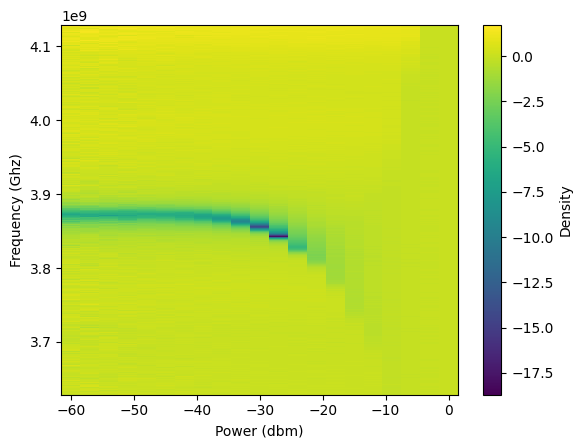

[3.628638e+09 3.628888e+09 3.629138e+09 ... 4.128138e+09 4.128388e+09
 4.128638e+09]


In [70]:
ds = PowerScanVNA(exp, run_id=518)
#ds.normalize_data_vna(run_id_bg = 24)
ds.normalize_data_from_index()
freq = ds.freq
mag = ds.mag_norm
phase = ds.phase_norm
cData = ds.cData_norm
power = ds.power
plt.pcolormesh(power, freq, mag)
plt.colorbar(label='Density')
plt.xlabel('Power (dbm)')
plt.ylabel('Frequency (Ghz)')
plt.show()
power = power - 95
power =  10**(power/10)*10**-3/(10**-15) #fw
mag = 10**(mag/20)
print(freq)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 4002
    # variables        = 6
    chi-square         = 6.43439411
    reduced chi-square = 0.00161021
    Akaike info crit   = -25732.4331
    Bayesian info crit = -25694.6658
    R-squared          = np.complex128(210530118875159.03+959857471919558.2j)
[[Variables]]
    wr:     3.87228767 +/- 9.7826e-04 (0.03%) (init = 3.872288)
    kc:     0.01789146 +/- 0.00155070 (8.67%) (init = 0.01789146)
    ki:     0.00677881 +/- 0.00206095 (30.40%) (init = 0.0067788)
    a:      1.02926598 +/- 0.02421242 (2.35%) (init = 1.029266)
    alpha:  21.3214291 +/- 0.64158693 (3.01%) (init = 21.32142)
    delay:  0.02681626 +/- 0.02630576 (98.10%) (init = -0.02681667)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, delay) = -0.9993
    C(kc, delay)    = -0.4089
    C(kc, alpha)    = +0.4084
    C(kc, ki)       = +0.3144
    C(ki, a)        = +0.3041
    C(kc, a)        = +0.123

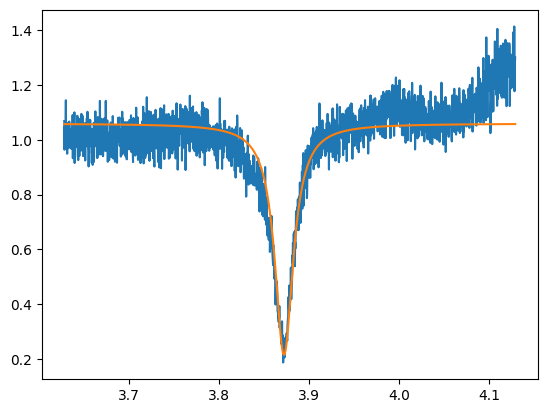

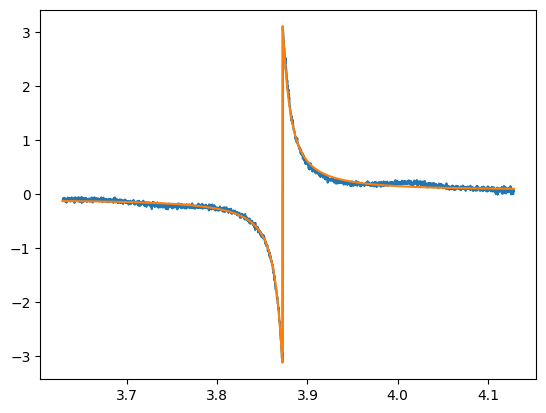

In [72]:
model_func = S11_linear_fitting

for i in range(1):

    # define the parameters to be fixed during the fit
    fixed_params = []
    data_to_fit = cData[:,i]
    # define the initial guesses for the parameters
    guesses = {}
    guesses['wr'] = 3.87228772 
    guesses['kc'] = 0.01789146 
    guesses['ki'] = 0.00677880 
    guesses['resonator_dephasing'] = 0.0005192369715378244
    #guesses['resonator_dephasing'] = 0.0000
    guesses['a'] =  1.02926601 
    guesses['alpha'] =21.3214191 
    guesses['delay'] = -0.02681667 

    # create the lmfit.Parameters object and adjust some settings
    params=lmfit.Parameters()
    signature = inspect.signature(model_func)
    parameter_names = [param.name for param in signature.parameters.values() if param.name not in ['w']]
    #fixed_params = parameter_names
    for name in parameter_names:
        params.add(name, value=guesses[name], vary=True)
    for name in fixed_params:
        params[name].vary = False

    params['kc'].min = 0
    params['ki'].min = 0
    params['wr'].min = 0
    #params['resonator_dephasing'].min = 0
    params['a'].min = 0

    # fit the data
    model = lmfit.Model(model_func, independent_vars=['w'])
    result = model.fit(data_to_fit, params, w=freq/1e9, scale_covar=False)

    fitted_data = result.best_fit
    fitted_values = result.best_values
    fitted_params = result.params

    print(lmfit.fit_report(result))
    plt.figure()
    plt.plot(freq/1e9, abs(cData[:,i])**2)
    plt.plot(freq/1e9, abs(fitted_data)**2)
    plt.figure()
    plt.plot(freq/1e9, np.angle(cData[:,i]))
    plt.plot(freq/1e9, np.angle(fitted_data))

In [1]:
model_func = S11_non_linear_fitting
fit_K = []
fit_K_error = []
fit_dephasing = []
fit_dephasing_error = []
start_figure = 8
end_figure = 14
for i in range(start_figure, end_figure):

    # define the parameters to be fixed during the fit
    fixed_params = ['wr','a','kc','ki', 'alpha', 'delay','resonator_dephasing', 'power_feedline']
    #fixed_params = ['wr', 'alpha', 'delay', 'power_feedline', 'a', 'kc']
    data_to_fit = cData[:,i]
    # define the initial guesses for the parameters
    guesses = {}
    guesses['K'] = -0.00133973
    guesses['power_feedline'] = power[i]
    guesses['wr'] = 3.87228772 
    guesses['kc'] = 0.01789146 
    guesses['ki'] = 0.00677880 
    guesses['resonator_dephasing'] = 0.001
    #guesses['resonator_dephasing'] = 0.0000
    guesses['a'] =  1.02926601 
    guesses['alpha'] = 21.3214388 
    guesses['delay'] = 0.02681584 

    # create the lmfit.Parameters object and adjust some settings
    params=lmfit.Parameters()
    signature = inspect.signature(model_func)
    parameter_names = [param.name for param in signature.parameters.values() if param.name not in ['w']]
    #fixed_params = parameter_names
    for name in parameter_names:
        params.add(name, value=guesses[name], vary=True)
    for name in fixed_params:
        params[name].vary = False

    #params['kc'].min = 0
    params['K'].max = 0
    #params['wr'].min = 0
    #params['resonator_dephasing'].min = 0
    #params['a'].min = 0

    # fit the data
    model = lmfit.Model(model_func, independent_vars=['w'])
    result = model.fit(data_to_fit, params, w=freq/1e9, scale_covar=False)
    fitted_data = result.best_fit
    fitted_values = result.best_values
    fitted_params = result.params
    
    fit_K.append(fitted_params['K'].value)
    fit_K_error.append(fitted_params['K'].stderr)
    fit_dephasing.append(fitted_params['resonator_dephasing'].value)
    fit_dephasing_error.append(fitted_params['resonator_dephasing'].stderr)
    
    plt.figure()
    plt.plot(freq/1e9, abs(cData[:,i])**2)
    plt.plot(freq/1e9, abs(fitted_data)**2)
    plt.xlabel('Pump Frequency (GHz)')
    plt.ylabel('S11 Normalized Amplitude')
    plt.show()
    plt.figure()
    plt.plot(freq/1e9, np.angle(cData[:,i]))
    plt.plot(freq/1e9, np.angle(fitted_data))
    plt.xlabel('Pump Frequency (GHz)')
    plt.ylabel('S11 Normalized Phase amplitude')
    plt.show()
fit_K = np.array(fit_K) * 1000
fit_K_error =np.array(fit_K_error) *1000
fit_dephasing = np.array(fit_dephasing) *1000
fit_dephasing_error = np.array(fit_dephasing_error) *1000

NameError: name 'S11_non_linear_fitting' is not defined

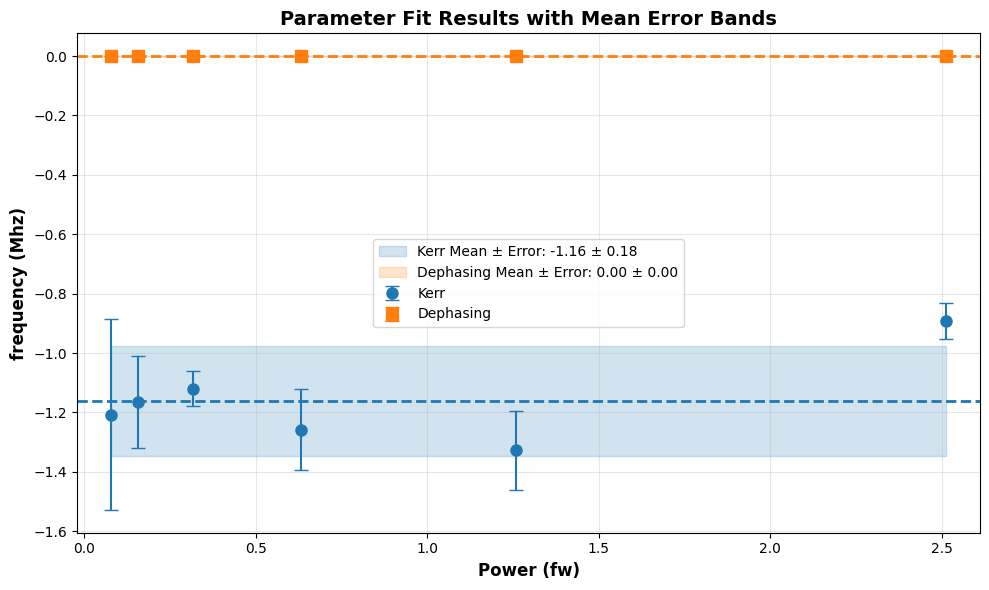

In [76]:
power_array = power[start_figure:end_figure]
mean_fit_K = np.mean(np.array(fit_K))
mean_fit_K_error = np.sqrt(np.sum(np.array(fit_K_error)**2)/(len(power_array)-1))
mean_fit_dephasing = np.mean(np.array(fit_dephasing))
mean_fit_dephasing_error = np.sqrt(np.sum(np.array(fit_dephasing_error)**2)/(len(power_array)-1))  # Fixed typo in variable name

# Create figure with larger size
plt.figure(figsize=(10, 6))

# Plot individual points with error bars
plt.errorbar(power_array, fit_K, yerr=fit_K_error, 
             fmt='o', color='#1f77b4', markersize=8, capsize=5,
             label='Kerr')
plt.errorbar(power_array, fit_dephasing, yerr=fit_dephasing_error,
             fmt='s', color='#ff7f0e', markersize=8, capsize=5,
             label='Dephasing')

# Add horizontal lines for mean values
plt.axhline(mean_fit_K, color='#1f77b4', linestyle='--', linewidth=2)
plt.axhline(mean_fit_dephasing, color='#ff7f0e', linestyle='--', linewidth=2)

# Add color bands for mean errors
plt.fill_between(power_array, 
                 mean_fit_K - mean_fit_K_error, 
                 mean_fit_K + mean_fit_K_error,
                 color='#1f77b4', alpha=0.2,
                 label=f'Kerr Mean ± Error: {mean_fit_K:.2f} ± {mean_fit_K_error:.2f}')

plt.fill_between(power_array,
                 mean_fit_dephasing - mean_fit_dephasing_error,
                 mean_fit_dephasing + mean_fit_dephasing_error,
                 color='#ff7f0e', alpha=0.2,
                 label=f'Dephasing Mean ± Error: {mean_fit_dephasing:.2f} ± {mean_fit_dephasing_error:.2f}')

# Add labels and styling
plt.xlabel('Power (fw)', fontsize=12, fontweight='bold')
plt.ylabel('frequency (Mhz)', fontsize=12, fontweight='bold')
plt.title('Parameter Fit Results with Mean Error Bands', fontsize=14, fontweight='bold')
plt.legend(frameon=True, loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Customize ticks and limits if needed
plt.xlim(min(power_array)-0.1, max(power_array)+0.1)

plt.show()

In [92]:
database = '/Users/a1234/desktop/data/2025_02_26_GaAs_W3Weg_JJ_3x2_LowFreq_circulator.db'
connection = connect(database)
exp = qc.load_experiment(1, conn=connection)

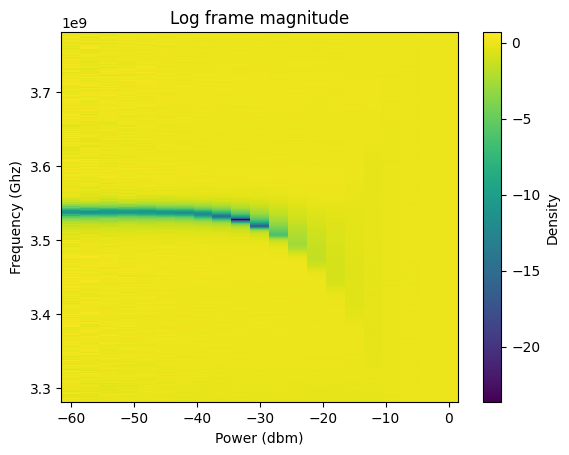

[3.28150e+09 3.28175e+09 3.28200e+09 ... 3.78100e+09 3.78125e+09
 3.78150e+09]


In [93]:
ds = PowerScanVNA(exp, run_id=231)
#ds.normalize_data_vna(run_id_bg = 24)
ds.normalize_data_from_index()
freq = ds.freq
mag = ds.mag_norm
phase = ds.phase_norm
cData = ds.cData_norm
power = ds.power
plt.pcolormesh(power, freq,mag)
plt.colorbar(label='Density')
plt.xlabel('Power (dbm)')
plt.ylabel('Frequency (Ghz)')
plt.title('Log frame magnitude')
plt.show()
power = power - 95
power =  10**(power/10)*10**-3/(10**-15) #fw
mag = 10**(mag/20)
print(freq)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 4002
    # variables        = 6
    chi-square         = 6.18755802
    reduced chi-square = 0.00154844
    Akaike info crit   = -25888.9801
    Bayesian info crit = -25851.2128
    R-squared          = np.complex128(2252275973515981.5-562558945264668.1j)
[[Variables]]
    wr:     3.53855160 +/- 0.00111724 (0.03%) (init = 3.537557)
    kc:     0.01653476 +/- 0.00161485 (9.77%) (init = 0.01653468)
    ki:     0.00883399 +/- 0.00242505 (27.45%) (init = 0.00883386)
    a:      1.00946279 +/- 0.02428438 (2.41%) (init = 1.009248)
    alpha:  8.72899278 +/- 0.59712273 (6.84%) (init = 8.728422)
    delay:  0.03237447 +/- 0.02689316 (83.07%) (init = -0.0326441)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, delay) = -0.9992
    C(kc, delay)    = -0.4130
    C(kc, alpha)    = +0.4130
    C(kc, ki)       = +0.3886
    C(ki, a)        = +0.2944
    C(kc, a)        = +0.157

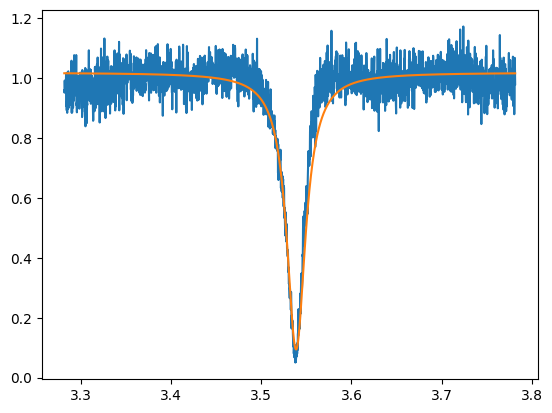

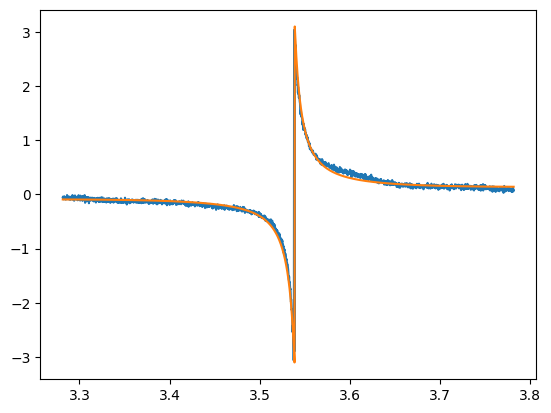

In [94]:
model_func = S11_linear_fitting

for i in range(1):

    # define the parameters to be fixed during the fit
    fixed_params = []
    data_to_fit = cData[:,i]
    # define the initial guesses for the parameters
    guesses = {}
    guesses['wr'] = 3.5375573941706606
    guesses['kc'] = 0.01653468 
    guesses['ki'] = 0.00883386 
    guesses['resonator_dephasing'] = 0.0005192369715378244
    #guesses['resonator_dephasing'] = 0.0000
    guesses['a'] =  1.00924845 
    guesses['alpha'] = 8.72842167 
    guesses['delay'] = -0.03264410 

    # create the lmfit.Parameters object and adjust some settings
    params=lmfit.Parameters()
    signature = inspect.signature(model_func)
    parameter_names = [param.name for param in signature.parameters.values() if param.name not in ['w']]
    #fixed_params = parameter_names
    for name in parameter_names:
        params.add(name, value=guesses[name], vary=True)
    for name in fixed_params:
        params[name].vary = False

    params['kc'].min = 0
    params['ki'].min = 0
    params['wr'].min = 0
    #params['resonator_dephasing'].min = 0
    params['a'].min = 0

    # fit the data
    model = lmfit.Model(model_func, independent_vars=['w'])
    result = model.fit(data_to_fit, params, w=freq/1e9, scale_covar=False)

    fitted_data = result.best_fit
    fitted_values = result.best_values
    fitted_params = result.params

    print(lmfit.fit_report(result))
    plt.figure()
    plt.plot(freq/1e9, abs(cData[:,i])**2)
    plt.plot(freq/1e9, abs(fitted_data)**2)
    plt.figure()
    plt.plot(freq/1e9, np.angle(cData[:,i]))
    plt.plot(freq/1e9, np.angle(fitted_data))

[np.float64(0.0015740401982366145)]


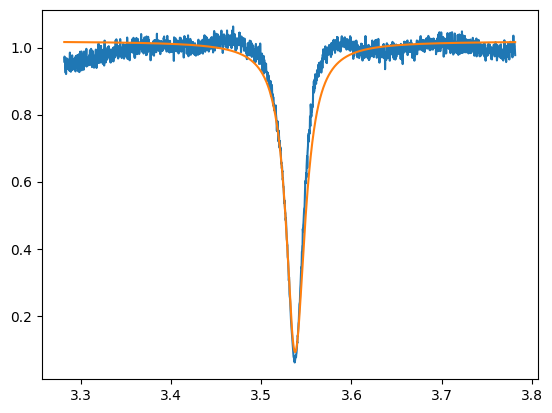

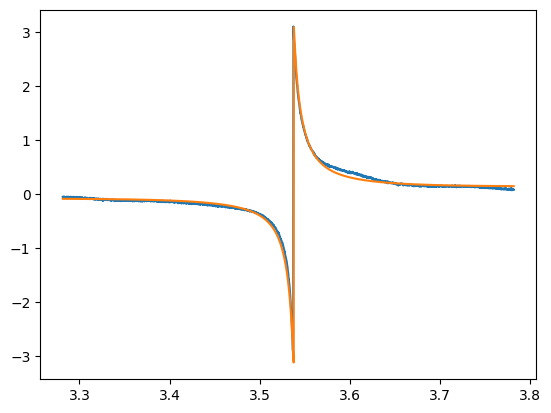

[np.float64(0.0015740401982366145), np.float64(0.0007843048634463679)]


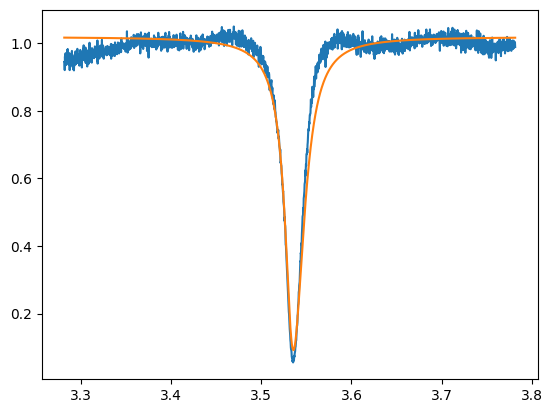

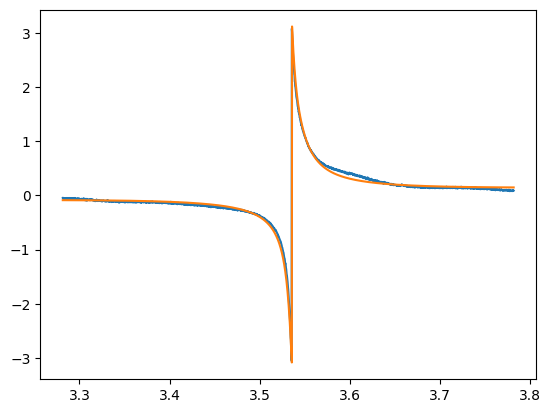

[np.float64(0.0015740401982366145), np.float64(0.0007843048634463679), np.float64(0.0003864306101741055)]


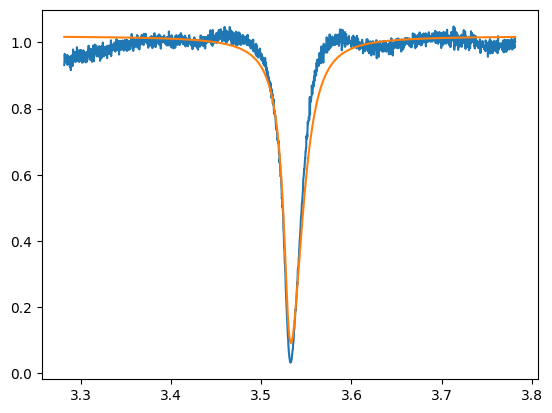

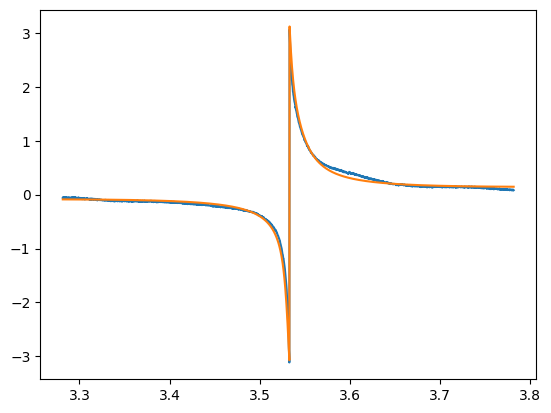

[np.float64(0.0015740401982366145), np.float64(0.0007843048634463679), np.float64(0.0003864306101741055), np.float64(0.00018143054748075984)]


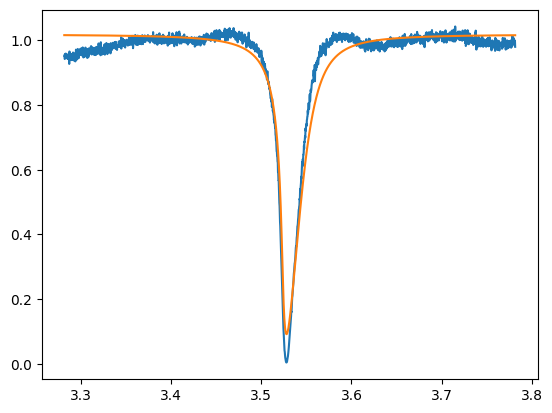

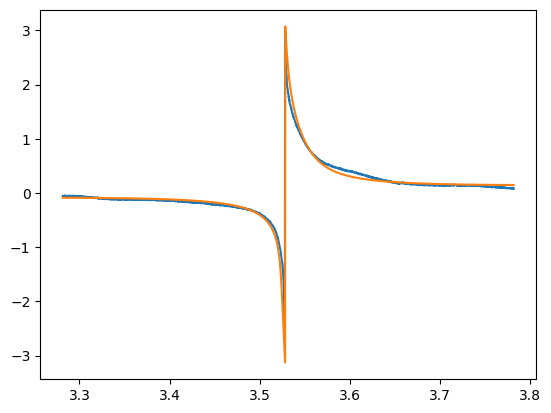

[[-0.54876714]
 [ 0.55355206]
 [-0.00478492]]
[np.float64(0.5535520649333862)]
[[-0.54791633]
 [ 0.55435557]
 [-0.00643924]]
[np.float64(0.5543555740441092)]
[[-0.68878317]
 [ 0.6289572 ]
 [ 0.05982597]]
[np.float64(0.6289571994201206)]
[[-0.50709919]
 [ 0.5858162 ]
 [-0.07871701]]
[np.float64(0.5858161980770962)]
[[-0.506014  ]
 [ 0.58649394]
 [-0.08047993]]
[np.float64(0.5864939360186062)]
[[-0.33718261]
 [ 0.6344426 ]
 [-0.29725999]]
[np.float64(0.6344425982913323)]
[[-0.33263997]
 [ 0.63461022]
 [-0.30197025]]
[np.float64(0.634610220669728)]
[[-0.32973823]
 [ 0.63469398]
 [-0.30495575]]
[np.float64(0.6346939807937182)]
[[-0.327986  ]
 [ 0.63473585]
 [-0.30674985]]
[np.float64(0.6347358481087024)]
[[-0.32698807]
 [ 0.63475678]
 [-0.30776871]]
[np.float64(0.634756778577122)]
[[-0.32644716]
 [ 0.63476724]
 [-0.30832009]]
[np.float64(0.6347672430188861)]
[[-0.32616397]
 [ 0.63477248]
 [-0.3086085 ]]
[np.float64(0.6347724750376)]
[[-0.32601884]
 [ 0.63477509]
 [-0.30875625]]
[np.float64

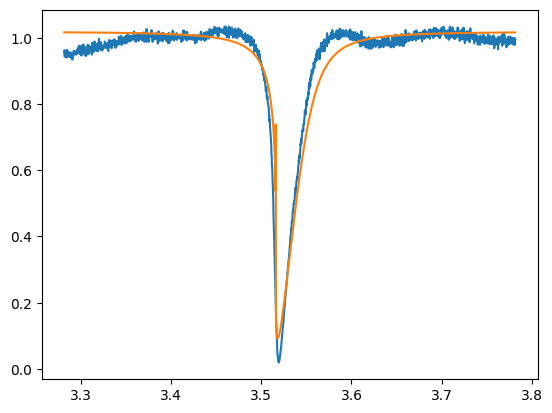

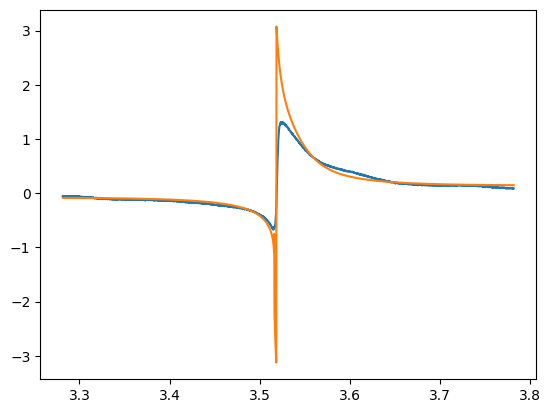

[[-0.83886392]
 [ 1.49843329]
 [ 0.97968097]]
[np.float64(1.4984332920309804)]
[[-0.83886392]
 [ 1.49843329]
 [ 0.97968097]]
[np.float64(1.4984332920309766)]
[[-0.83886392]
 [ 1.49843329]
 [ 0.97968097]]
[np.float64(1.4984332920309766)]
[[-0.83886392]
 [ 1.49843329]
 [ 0.97968097]]
[np.float64(1.4984332920309766)]
[[-0.83847166]
 [ 1.49843447]
 [ 0.97945961]]
[np.float64(1.498434470047823)]
[[-0.78119126]
 [ 1.43595143]
 [ 1.15592651]]
[np.float64(1.435951434696461)]
[[-0.7808727 ]
 [ 1.43594663]
 [ 1.15566356]]
[np.float64(1.4359466334939646)]
[[-0.83466356]
 [ 1.40758425]
 [ 1.19644588]]
[np.float64(1.4075842515928254)]
[[-0.82201771]
 [ 1.41567543]
 [ 1.19903057]]
[np.float64(1.4156754329065802)]
[[-0.88310927]
 [ 1.4307849 ]
 [ 1.13964672]]
[np.float64(1.430784902615663)]
[[-0.88932547]
 [ 1.43476949]
 [ 1.15905113]]
[np.float64(1.4347694905794304)]
[[-0.77112328]
 [ 1.43581638]
 [ 1.14859005]]
[np.float64(1.4358163803043842)]
[[-0.77075122]
 [ 1.43581183]
 [ 1.14835353]]
[np.float

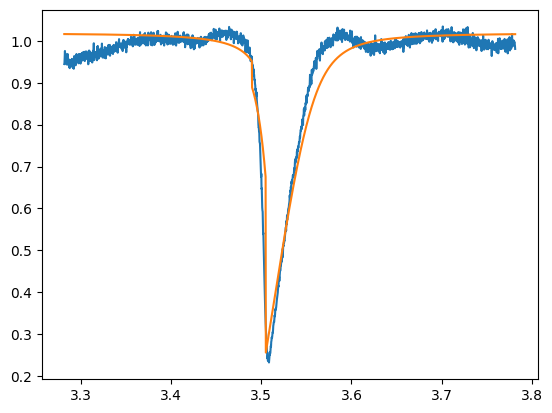

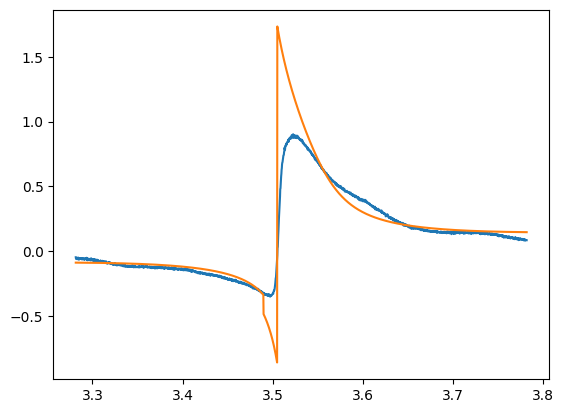

[[-0.70921683]
 [ 1.3748813 ]
 [ 1.25559877]]
[np.float64(1.3748813030596596)]
[[-0.70921683]
 [ 1.3748813 ]
 [ 1.25559877]]
[np.float64(1.3748813030596578)]
[[-0.70921683]
 [ 1.3748813 ]
 [ 1.25559877]]
[np.float64(1.3748813030596578)]
[[-0.70921683]
 [ 1.3748813 ]
 [ 1.25559877]]
[np.float64(1.3748813030596578)]
[[-0.70909875]
 [ 1.37487933]
 [ 1.25537261]]
[np.float64(1.3748793283727683)]
[[-0.61709685]
 [ 1.36374888]
 [ 1.26110283]]
[np.float64(1.3637488794861825)]
[[-0.61690449]
 [ 1.36374735]
 [ 1.26095864]]
[np.float64(1.3637473515009266)]
[[-0.65350134]
 [ 1.36227806]
 [ 1.28159058]]
[np.float64(1.3622780634921476)]
[[-0.65340029]
 [ 1.36227672]
 [ 1.2813354 ]]
[np.float64(1.3622767236550979)]
[[-0.59956326]
 [ 1.36180613]
 [ 1.2921721 ]]
[np.float64(1.3618061316857746)]
[[-0.59956326]
 [ 1.36180613]
 [ 1.2921721 ]]
[np.float64(1.3618061316857746)]
[[-0.62217688]
 [ 1.36195943]
 [ 1.28695479]]
[np.float64(1.361959431396264)]
[[-0.64249835]
 [ 1.36215387]
 [ 1.26319859]]
[np.flo

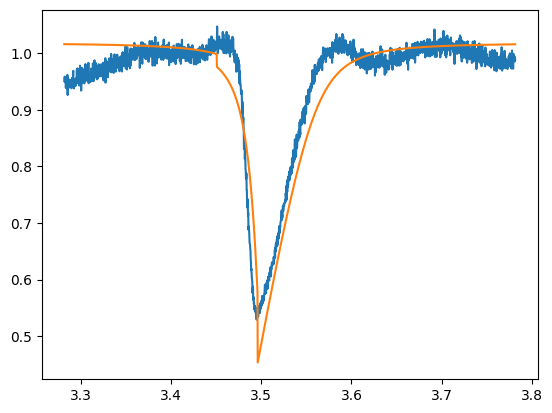

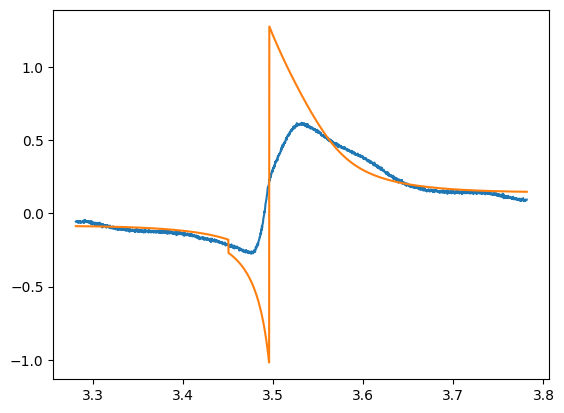

[[-0.43686392]
 [ 1.34305195]
 [ 1.31281197]]
[np.float64(1.3430519476368943)]
[[-0.43686392]
 [ 1.34305195]
 [ 1.31281197]]
[np.float64(1.3430519476369591)]
[[-0.43686392]
 [ 1.34305195]
 [ 1.31281197]]
[np.float64(1.3430519476369591)]
[[-0.43686392]
 [ 1.34305195]
 [ 1.31281197]]
[np.float64(1.3430519476369591)]
[[-0.43628839]
 [ 1.34305159]
 [ 1.31263607]]
[np.float64(1.343051592789026)]
[[-0.51480005]
 [ 1.34536349]
 [ 1.30739577]]
[np.float64(1.3453634894639919)]
[[-0.51471931]
 [ 1.34536313]
 [ 1.30722632]]
[np.float64(1.3453631274842024)]
[[-0.55411526]
 [ 1.34895959]
 [ 1.30288995]]
[np.float64(1.3489595882423049)]
[[-0.55402944]
 [ 1.34895879]
 [ 1.30268241]]
[np.float64(1.3489587866389732)]
[[-0.56945415]
 [ 1.35359716]
 [ 1.28918307]]
[np.float64(1.3535971596693928)]
[[-0.5693209 ]
 [ 1.35359672]
 [ 1.28901655]]
[np.float64(1.3535967187491746)]
[[-0.55953382]
 [ 1.35755918]
 [ 1.27588906]]
[np.float64(1.3575591794990243)]
[[-0.55953382]
 [ 1.35755918]
 [ 1.27588906]]
[np.flo

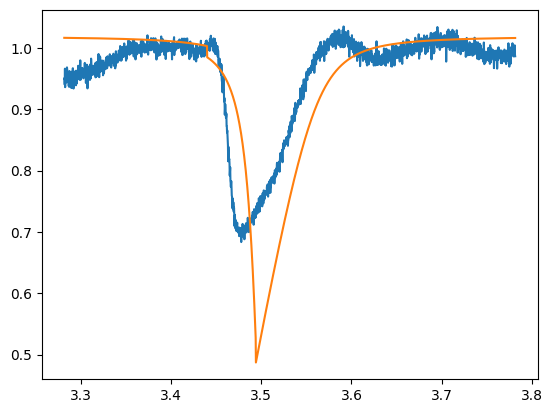

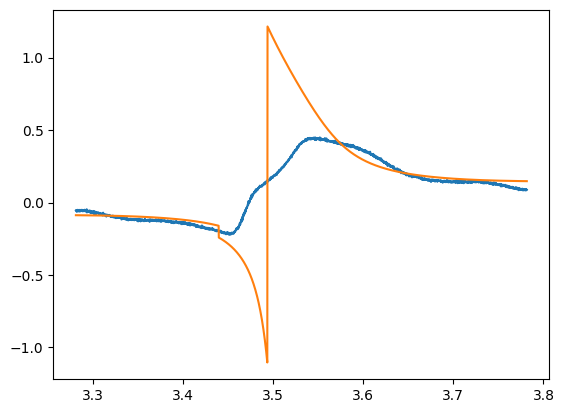

[[-0.3139861 ]
 [ 1.18084207]
 [ 1.03299686]]
[np.float64(1.180842065575572)]
[[-0.3139861 ]
 [ 1.18084207]
 [ 1.03299686]]
[np.float64(1.1808420655756344)]
[[-0.3139861 ]
 [ 1.18084207]
 [ 1.03299686]]
[np.float64(1.1808420655756344)]
[[-0.3139861 ]
 [ 1.18084207]
 [ 1.03299686]]
[np.float64(1.1808420655756344)]
[[-0.31392896]
 [ 1.1808228 ]
 [ 1.03297168]]
[np.float64(1.180822801546976)]
[[-0.30054225]
 [ 1.11140271]
 [ 0.94560067]]
[np.float64(1.1114027062346676)]
[[-0.30048875]
 [ 1.11138407]
 [ 0.945578  ]]
[np.float64(1.111384073633297)]
[[-0.28994777]
 [ 1.03053888]
 [ 0.85018536]]
[np.float64(1.0305388754844511)]
[[-0.28990583]
 [ 1.03052128]
 [ 0.85016517]]
[np.float64(1.0305212771839802)]
[[-0.27514615]
 [ 0.94761728]
 [ 0.75739052]]
[np.float64(0.9476172770671644)]
[[-0.2751096 ]
 [ 0.94760091]
 [ 0.75737262]]
[np.float64(0.9476009060556667)]
[[-0.25885291]
 [ 0.87189412]
 [ 0.6761793 ]]
[np.float64(0.8718941204197351)]
[[-0.25881855]
 [ 0.87187895]
 [ 0.67616333]]
[np.float

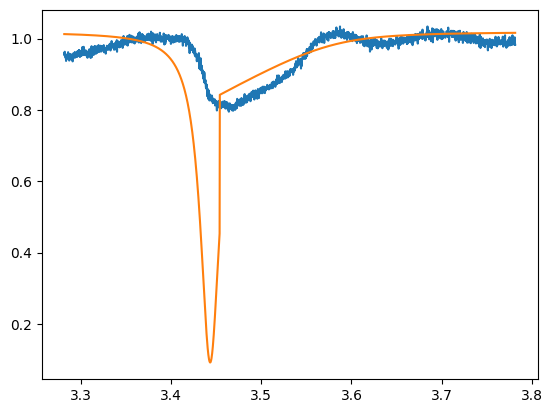

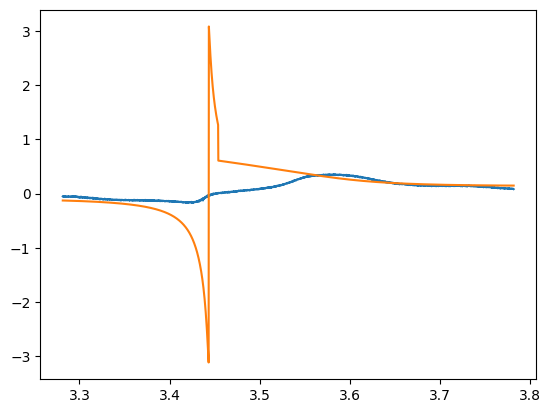

In [102]:
model_func = S11_non_linear_fitting
fit_K = []
fit_K_error = []
fit_dephasing = []
fit_dephasing_error = []
start_figure = 6
end_figure = 15
for i in range(start_figure, end_figure):

    fixed_params = ['wr','ki','kc','a', 'alpha', 'delay','resonator_dephasing', 'power_feedline']
    #fixed_params = ['a', 'alpha', 'delay', 'power_feedline']
    data_to_fit = cData[:,i]
    # define the initial guesses for the parameters
    guesses = {}
    guesses['wr'] =  3.53855159 
    guesses['kc'] = 0.01653469 
    guesses['ki'] =   0.00889825 
    guesses['K'] = -0.00130792
    guesses['power_feedline'] = power[i]
    guesses['resonator_dephasing'] = 0.000
    guesses['a'] =  1.00924845 
    guesses['alpha'] = 8.72842167 
    guesses['delay'] = 0.03264410 

    # create the lmfit.Parameters object and adjust some settings
    params=lmfit.Parameters()
    signature = inspect.signature(model_func)
    parameter_names = [param.name for param in signature.parameters.values() if param.name not in ['w']]
    #fixed_params = parameter_names
    for name in parameter_names:
        params.add(name, value=guesses[name], vary=True)
    for name in fixed_params:
        params[name].vary = False

    params['K'].max = 0
    params['resonator_dephasing'].min = 0

    # fit the data
    model = lmfit.Model(model_func, independent_vars=['w'])
    result = model.fit(data_to_fit, params, w=freq/1e9, scale_covar=False)
    fitted_data = result.best_fit
    fitted_values = result.best_values
    fitted_params = result.params
    
    fit_K.append(fitted_params['K'].value)
    fit_K_error.append(fitted_params['K'].stderr)
    print(fit_K_error)
    fit_dephasing.append(fitted_params['resonator_dephasing'].value)
    fit_dephasing_error.append(fitted_params['resonator_dephasing'].stderr)
    
    plt.figure()
    plt.plot(freq/1e9, abs(cData[:,i])**2)
    plt.plot(freq/1e9, abs(fitted_data)**2)
    plt.figure()
    plt.plot(freq/1e9, np.angle(cData[:,i]))
    plt.plot(freq/1e9, np.angle(fitted_data))
    plt.show()
fit_K = np.array(fit_K) * 1000
fit_K_error =np.array(fit_K_error) *1000
fit_dephasing = np.array(fit_dephasing) *1000
fit_dephasing_error = np.array(fit_dephasing_error) *1000

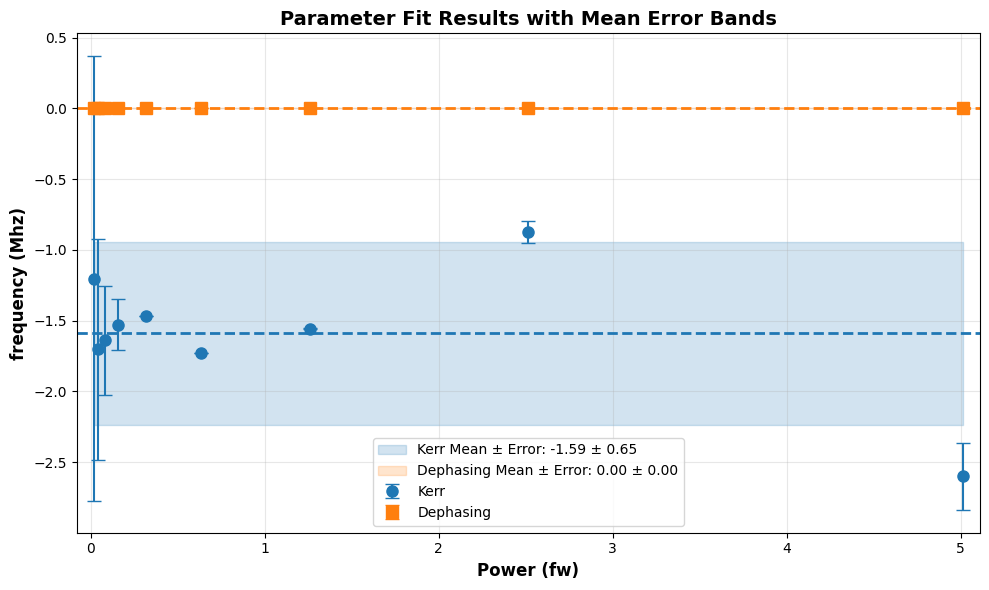

In [103]:
power_array = power[start_figure:end_figure]
mean_fit_K = np.mean(np.array(fit_K))
mean_fit_K_error = np.sqrt(np.sum(np.array(fit_K_error)**2)/(len(power_array)-1))
mean_fit_dephasing = np.mean(np.array(fit_dephasing))
mean_fit_dephasing_error = np.sqrt(np.sum(np.array(fit_dephasing_error)**2)/(len(power_array)-1))  # Fixed typo in variable name

# Create figure with larger size
plt.figure(figsize=(10, 6))

# Plot individual points with error bars
plt.errorbar(power_array, fit_K, yerr=fit_K_error, 
             fmt='o', color='#1f77b4', markersize=8, capsize=5,
             label='Kerr')
plt.errorbar(power_array, fit_dephasing, yerr=fit_dephasing_error,
             fmt='s', color='#ff7f0e', markersize=8, capsize=5,
             label='Dephasing')

# Add horizontal lines for mean values
plt.axhline(mean_fit_K, color='#1f77b4', linestyle='--', linewidth=2)
plt.axhline(mean_fit_dephasing, color='#ff7f0e', linestyle='--', linewidth=2)

# Add color bands for mean errors
plt.fill_between(power_array, 
                 mean_fit_K - mean_fit_K_error, 
                 mean_fit_K + mean_fit_K_error,
                 color='#1f77b4', alpha=0.2,
                 label=f'Kerr Mean ± Error: {mean_fit_K:.2f} ± {mean_fit_K_error:.2f}')

plt.fill_between(power_array,
                 mean_fit_dephasing - mean_fit_dephasing_error,
                 mean_fit_dephasing + mean_fit_dephasing_error,
                 color='#ff7f0e', alpha=0.2,
                 label=f'Dephasing Mean ± Error: {mean_fit_dephasing:.2f} ± {mean_fit_dephasing_error:.2f}')

# Add labels and styling
plt.xlabel('Power (fw)', fontsize=12, fontweight='bold')
plt.ylabel('frequency (Mhz)', fontsize=12, fontweight='bold')
plt.title('Parameter Fit Results with Mean Error Bands', fontsize=14, fontweight='bold')
plt.legend(frameon=True, loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Customize ticks and limits if needed
plt.xlim(min(power_array)-0.1, max(power_array)+0.1)

plt.show()